In [ ]:
#!pip install keras tensorflow

In [1]:
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('../datasets/train.txt', sep='\t', header=None, names=['Title', 'Origin', 'Genre', 'Director', 'Plot'])
print(data.head())

                       Title     Origin    Genre       Director  \
0               Ela Cheppanu     Telugu  romance         Ramana   
1  A Nightmare on Elm Street   American   horror   Samuel Bayer   
2            American Gothic   American   horror     John Hough   
3                       Gang  Bollywood    crime    Mazhar Khan   
4         Intimate Relations    British    drama  Charles Frank   

                                                Plot  
0  Sekhar (Tarun) is a graduate from IIM and work...  
1  Kris Fowles (Katie Cassidy) goes to the Spring...  
2  Cynthia is traumatized by the death of her bab...  
3  Four friends, Gangu (Jackie Shroff), Abdul (Na...  
4  Crisis in a middle-class family when the son f...  


In [3]:
stop_words = ["the", "to", "of", "a", 'and', 'is', 'his', 'in', 'he', 
            'that', 'her', "with", "by", "for", "him", "the", "as", "who",
            "on", "she", "but", "from", "has", "they", "an", "at", "their", "are",
            "into", "he", "out", "it", "up", "be", "was", "when", "not", "them", "which",
            "then", "after", "about", "where", "one", "have", "When", "After", "tells", "him.",
            "back", "She", "will", "while", "all", "two", "In", "had", "been", "They",
            "get", "only", "also", "before", "off", "being", "As", "goes", "takes",
            "this", "other", "take", "tries", "A", "her.", "go", "gets", "can", "man", "so",
            "over", "through", "down", "help", "new", "him,", "now", "comes", "next", "himself",
            "later", "however", "away", "there", "during", "both", "first", "again", "no", "way", "own",
            "some", "another", "more", "becomes", "make", "does", "what", "begins", "meanwhile", "just",
            "asks", "if", "because", "soon", "having", "its", "eventually", "come", "still", "between", "father",
            "house", "finds"
            ]

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.strip(' ')
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

data['Clean_Plot'] = data['Plot'].apply(preprocess_text)

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_47536/1285755728.py:27: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


## GloVe as feature provider

In [25]:
import numpy as np
glove_file = '../glove.6B/glove.6B.100d.txt'

# loads glove and embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding_vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding_vector
    return embeddings_index


embeddings_index = load_glove_embeddings(glove_file)
print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [14]:
from sklearn.preprocessing import MinMaxScaler

def get_average_embedding(text, embeddings_index, embedding_dim=100):
    words = text.split()
    embedding_matrix = []
    
    for word in words:
        if word in embeddings_index:  # Check if the word has a GloVe embedding
            embedding_matrix.append(embeddings_index[word])
        else:
            embedding_matrix.append(np.zeros(embedding_dim))  # Use a zero vector for unknown words
    
    if len(embedding_matrix) > 0:
        # Average the embeddings to get a single vector for the plot
        return np.mean(embedding_matrix, axis=0)
    else:
        return np.zeros(embedding_dim)  # Return a zero vector if no embeddings were found


embedding_dim = 100  # Adjust this based on the GloVe file used
X_embeddings = np.array([get_average_embedding(plot, embeddings_index, embedding_dim) for plot in X])

X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)
# Since Naive Bayes expects non-negative values, we scale the embeddings to [0, 1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((6432, 100), (1609, 100))

In [ ]:
# TODO using GloVe embeddings isn't working with Naive Bayes and I don't understand why
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_scaled, y_train)

y_pred = nb_classifier.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Tf-idf as feature provider

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Genre'])

tfidf = TfidfVectorizer(max_features=7000, min_df=20, stop_words=stop_words, ngram_range=(1, 3))
X = tfidf.fit_transform(data['Clean_Plot']).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.6488502175264139
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.55      0.58       202
           1       0.89      0.65      0.75       115
           2       0.55      0.48      0.51       223
           3       0.80      0.44      0.57       108
           4       0.50      0.67      0.57       319
           5       0.76      0.84      0.80       223
           6       0.56      0.55      0.56       186
           7       0.58      0.38      0.46        39
           8       0.89      0.94      0.91       194

    accuracy                           0.65      1609
   macro avg       0.68      0.61      0.64      1609
weighted avg       0.66      0.65      0.65      1609

Accuracy: 0.6488502175264139
Classification Report:
               precision    recall  f1-score   support

      action       0.62      0.55      0.58       202
   animation       0.89      0.65      0.75       115
      comedy       0.55   

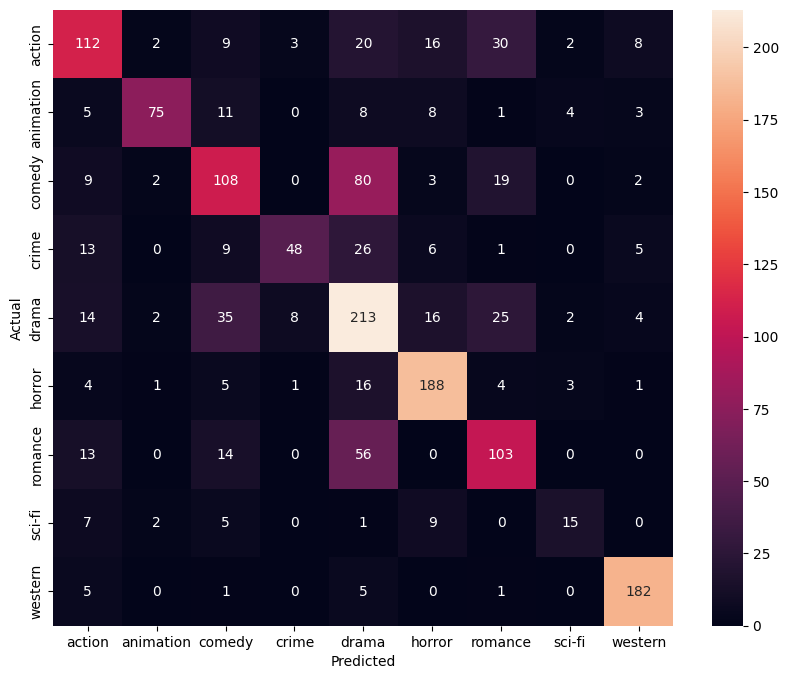

In [9]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB(alpha=0.1) # adjusting alpha got me way better results
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()